# CS5660 Final Project
## Topic Modeling on arXiv abstract data
Ryan Dielhenn
Joe Jimenez
CalStateLA

## Topic Modeling

### Def 1.
**Topic modeling** is an **unsupervised machine learning technique** that automatically identifies the abstract topics present within a collection of documents. It assumes that each document is a mixture of a small number of topics and that each topic is characterized by a distribution over words. The goal of topic modeling is to uncover the hidden thematic structure in large textual datasets, facilitating tasks such as organization, summarization, and discovery of patterns without prior annotation.

### Def 2.
* The problem of modeling text corpora and other collections of discrete data. The goal is to find short descriptions of the members of a collection that enable efficient processing of large collections while preserving the essential statistical relationships that are useful for basic tasks such as classification, novelty detection, summarization, and similarity and relevance judgments.


[1] Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.


### Traditional Topic Models and Their Limitation

* Traditional Approaches:
    * Latent Dirichlet Allocation (LDA)
    * Non-Negative Matrix Factorization (NMF)

* Bag-of-Words Assumption
    * Treat documents as a collection of individual words (e.g., ignores word order).

* Limitation:
    * Ignores the meaning and relationship between words.

### What is a Bag-of-Words?
* A bag-of-words is a representation of text that describes the occurrence of words within a document.
    
    * A vocabulary
    * A measure of the presence of know words.

![image.png](attachment:957fcc09-79cc-4181-90c3-a6bd733c7e4f.png)


In [1]:
from tensorflow import keras
from typing import List
from tensorflow.keras.preprocessing.text import Tokenizer

sentence = ["John likes to watch movies. Mary likes movies too."]


def print_bow(sentence: List[str]) -> None:
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentence)
    sequences = tokenizer.texts_to_sequences(sentence)
    word_index = tokenizer.word_index
    bow = {}
    for key in word_index:
        bow[key] = sequences[0].count(word_index[key])

    print(f"Bag of word sentence 1:\n{bow}")
    print(f"{word_index}")
    print(f"We found {len(word_index)} unique tokens.")


print_bow(sentence)

Bag of word sentence 1:
{'likes': 2, 'movies': 2, 'john': 1, 'to': 1, 'watch': 1, 'mary': 1, 'too': 1}
{'likes': 1, 'movies': 2, 'john': 3, 'to': 4, 'watch': 5, 'mary': 6, 'too': 7}
We found 7 unique tokens.


In [2]:
print("John likes to watch movies. Mary likes movies too.")

John likes to watch movies. Mary likes movies too.


### BERTopic [(🔗)](https://maartengr.github.io/BERTopic/index.html)
BERTopic is a topic modeling technique that leverages 🤗 transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

### Visual Overview

BERTopic can be viewed as a sequence of steps to create its topic representations. BERTopic generates topics from text through a four-step process:

1. **Embedding**: Each document is first transformed into a numerical vector using a pre-trained language model such as BERT. This step captures the semantic meaning and contextual nuances of the text.

2. **Dimensionality Reduction**: Because the resulting vectors are high-dimensional, a dimensionality reduction technique (e.g., UMAP) is applied to simplify the representation while preserving important structure, making clustering more efficient and effective.

3. **Clustering**: The reduced vectors are then clustered into groups, where each cluster corresponds to a potential topic.

4. **Topic Representation**: For each cluster, BERTopic applies a technique called class-based TF-IDF to identify the key words that best characterize the topic.

This end-to-end process enables BERTopic to generate clear, interpretable, and contextually rich topics, often outperforming traditional topic modeling methods.

![image.png](attachment:6c85ca13-6cfa-4a64-9443-bbe4b29e41c2.png)![image.png](attachment:4a208f14-75db-4b07-acb8-c0998be65fe9.png)

## Install required libraries

In [3]:
# BERTopic library
!pip install -q BERTopic

# Visualization Libraries
!pip install datamapplot matplotlib

# Tokenization and ollama for running llm locally
!pip install -q openai tiktoken ollama

# Cuda Drivers for running LLM on colab
!apt-get update && apt-get install -y pciutils cuda-drivers

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 3,917 B in 1s (3,023 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (

## Import required packages

In [4]:
# Core
import os
import sys
import re
import time
import subprocess
import ast

# Data
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

# Topic modeling
from bertopic import BERTopic
from bertopic.representation import (
    KeyBERTInspired,
    MaximalMarginalRelevance,
    TextGeneration,
    OpenAI as RepresentationOpenAI
)
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

# Visualization
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import datamapplot

# External services
from google.colab import drive
from openai import OpenAI
import openai

# Utilities for fetching abstracts from the arXiv api
sys.path.insert(0, '/content/drive/MyDrive/CSULA/CS5660/arXiv_topic_modeling')
from utils import fetch_arxiv_abstracts
print("✅ Imports successful!")

✅ Imports successful!


## BERTopic Quick Start

### 📄 Loading the Dataset

In [5]:
docs, titles = fetch_arxiv_abstracts(category='cs.AI', max_results=1000)

Fetched 100 abstracts so far...
Fetched 200 abstracts so far...
Fetched 300 abstracts so far...
Fetched 400 abstracts so far...
Fetched 500 abstracts so far...
Fetched 600 abstracts so far...
Fetched 700 abstracts so far...
Fetched 800 abstracts so far...
Fetched 900 abstracts so far...
Fetched 1000 abstracts so far...


In [6]:
docs[0]

'Ramp metering that uses traffic signals to regulate vehicle flows from the on-ramps has been widely implemented to improve vehicle mobility of the freeway. Previous studies generally update signal timings in real-time based on predefined traffic measures collected by point detectors, such as traffic volumes and occupancies. Comparing with point detectors, traffic cameras-which have been increasingly deployed on road networks-could cover larger areas and provide more detailed traffic information. In this work, we propose a deep reinforcement learning (DRL) method to explore the potential of traffic video data in improving the efficiency of ramp metering. The proposed method uses traffic video frames as inputs and learns the optimal control strategies directly from the high-dimensional visual inputs. A real-world case study demonstrates that, in comparison with a state-of-the-practice method, the proposed DRL method results in 1) lower travel times in the mainline, 2) shorter vehicle qu

`fetch_arXiv_abstracts` is a function from `utils/` that will return a certain number of abstracts from a category eg `cs.AI`. The arXiv api seems to have rate limiting so we may need a delay before fetching more data in the future.


### Building and Training the BERTopic Model

In [7]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)

After generating topics and their probabilities, we can access the frequent topics that were generated:

In [8]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,180,-1_the_and_of_to,"[the, and, of, to, in, we, on, for, is, data]",[Anomaly detection in supercomputers is a very...
1,0,509,0_the_of_to_and,"[the, of, to, and, in, we, that, is, for, this]",[Q-learning is one of the most popular methods...
2,1,30,1_the_text_chinese_translation,"[the, text, chinese, translation, of, and, wor...",[Regional language extraction from a natural s...
3,2,29,2_of_the_to_and,"[of, the, to, and, in, on, is, training, deep,...",[The last few years have brought advances in c...
4,3,25,3_dialogue_conversational_the_to,"[dialogue, conversational, the, to, and, we, o...",[There has been considerable progress made tow...
5,4,24,4_the_deep_of_networks,"[the, deep, of, networks, and, in, for, that, ...",[Deep neural networks (DNNs) generalize remark...
6,5,20,5_adversarial_attacks_the_to,"[adversarial, attacks, the, to, defense, we, p...",[The adversarial vulnerability of deep network...
7,6,20,6_fairness_fair_in_the,"[fairness, fair, in, the, we, and, of, that, t...",[Fair classification has been a topic of inten...
8,7,19,7_knowledge_and_embedding_graph,"[knowledge, and, embedding, graph, of, the, gr...",[Recent years have witnessed the successful ap...
9,8,18,8_causal_the_of_and,"[causal, the, of, and, bayesian, in, models, g...",[We consider testing and learning problems on ...


* -1 refers to all outliers and should typically be ignored.
* Next, let's take a look at the most frequent topic that was generated, topic 0:

In [9]:
topic_model.get_topic(0)

[('the', np.float64(0.038330938258236476)),
 ('of', np.float64(0.03430420197303314)),
 ('to', np.float64(0.03175060368053334)),
 ('and', np.float64(0.03094074233743973)),
 ('in', np.float64(0.029185063518231826)),
 ('we', np.float64(0.023982626462222316)),
 ('that', np.float64(0.02232114725864207)),
 ('is', np.float64(0.02199353746521777)),
 ('for', np.float64(0.02168321761937491)),
 ('this', np.float64(0.01951218251677108))]

Using `.get_document_info`, we can also extract information on a document level, such as their corresponding topics, probabilities, whether they are representative documents for a topic


In [10]:
topic_model.get_document_info(docs)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Ramp metering that uses traffic signals to reg...,0,0_the_of_to_and,"[the, of, to, and, in, we, that, is, for, this]",[Q-learning is one of the most popular methods...,the - of - to - and - in - we - that - is - fo...,1.000000,False
1,"Recently, deep reinforcement learning (DRL)-ba...",0,0_the_of_to_and,"[the, of, to, and, in, we, that, is, for, this]",[Q-learning is one of the most popular methods...,the - of - to - and - in - we - that - is - fo...,1.000000,False
2,"In this work, we study the protection that fuz...",5,5_adversarial_attacks_the_to,"[adversarial, attacks, the, to, defense, we, p...",[The adversarial vulnerability of deep network...,adversarial - attacks - the - to - defense - w...,1.000000,False
3,Portfolio-based algorithm selection has seen t...,0,0_the_of_to_and,"[the, of, to, and, in, we, that, is, for, this]",[Q-learning is one of the most popular methods...,the - of - to - and - in - we - that - is - fo...,1.000000,False
4,To quantify how well natural language understa...,3,3_dialogue_conversational_the_to,"[dialogue, conversational, the, to, and, we, o...",[There has been considerable progress made tow...,dialogue - conversational - the - to - and - w...,1.000000,True
...,...,...,...,...,...,...,...,...
995,Traffic prediction is a fundamental and vital ...,0,0_the_of_to_and,"[the, of, to, and, in, we, that, is, for, this]",[Q-learning is one of the most popular methods...,the - of - to - and - in - we - that - is - fo...,1.000000,False
996,Direct policy search is one of the most import...,0,0_the_of_to_and,"[the, of, to, and, in, we, that, is, for, this]",[Q-learning is one of the most popular methods...,the - of - to - and - in - we - that - is - fo...,1.000000,False
997,Word embeddings are a key component of high-pe...,1,1_the_text_chinese_translation,"[the, text, chinese, translation, of, and, wor...",[Regional language extraction from a natural s...,the - text - chinese - translation - of - and ...,0.829229,True
998,Knowledge tracing is a sequence prediction pro...,15,15_the_recommendation_items_to,"[the, recommendation, items, to, of, users, an...",[Cross-Domain Recommendation (CDR) and Cross-S...,the - recommendation - items - to - of - users...,0.936013,False


 ### Representation Models: Fine-tune Topic Representation

BERTopic uses a Bag-of-Words approach with class-based TF-IDF (c-TF-IDF) to quickly generate topic keywords without needing to re-train the model after clustering.
While this provides good initial topic representations, BERTopic also offers optional representation models for further fine-tuning.
These models can range from powerful GPT-like models to faster keyword extraction methods like KeyBERT, giving users flexibility to enhance topic quality as needed.

### LLM & Generative AI

Using LLMs such as GPT-4, and open source soultion, we can fine-tune topics to generate labels, summaries of the topics.

- Generate a set of keywords and documetns that describe a topic best using BERTopic's c-TF-IDF .
- Candidate keywords and documents are passed to the text generation model and asked to generate output that fits the topic best.


#### Prompt


In [11]:
prompt = """
I have topic that contains the following documents: \n[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the above information, can you give a short label of the topic?
"""

### Selecting Documents

Four of the most representative documents will be passed to `[Documents]`.


![image.png](attachment:a95c2c46-b540-4139-b7ed-afbf9dfe0827.png)

BERTopic works rather straightforward. It consists of 5 sequential steps: embedding documents, reducing embeddings in dimensionality, cluster embeddings, tokenize documents per cluster, and finally extract the best representing words per topic.
<br>
<div>
<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/e9b0d8cf-2e19-4bf1-beb4-4ff2d9fa5e2d" width="500"/>
</div>


In [12]:
!curl -fsSL https://ollama.ai/install.sh | sh

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to render group...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> NVIDIA GPU installed.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [13]:
os.environ.update({'LD_LIBRARY_PATH': '/usr/lib64-nvidia'})

def run_ollama_serve():
    subprocess.Popen(["nohup", "ollama", "serve"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

run_ollama_serve()
time.sleep(5)
print("Ollama server started.")

Ollama server started.


In [14]:
!ollama pull llama3

In [15]:
# Configure the client to use the local Ollama server
client = OpenAI(
    base_url='http://localhost:11434/v1',
    api_key='ollama', # dummy API key required by the client library
)

# Use the model you pulled (e.g., "llama3")
model_name = "llama3"

print(f"Sending request to {model_name}...")

# Example using the standard OpenAI client chat completion
try:
    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "user", "content": "Explain how to run an LLM locally in one sentence."}
        ],
        temperature=0.7,
    )
    print("\n--- Model Response ---")
    print(response.choices[0].message.content)
    print("----------------------")

except Exception as e:
    print(f"\nAn error occurred: {e}")
    print("Make sure the 'ollama serve' process is running in the background.")

# You can run !ollama ps again after this code executes to see the model usage
time.sleep(2)
!ollama ps


Sending request to llama3...

--- Model Response ---
To run a Large Language Model (LLM) locally, you need to first download the pre-trained model weights and then use a programming framework such as Python or Julia with libraries like Hugging Face Transformers or JuPyte, respectively, to load the model and fine-tune it on your own dataset or use it for inference tasks.
----------------------
NAME             ID              SIZE      PROCESSOR    CONTEXT    UNTIL              
llama3:latest    365c0bd3c000    5.2 GB    100% GPU     4096       4 minutes from now    


In [16]:
!curl http://localhost:11434/

Ollama is running

In [17]:
# Assuming bertopic and its dependencies are installed
# If not, run this line first: !pip install bertopic sentence-transformers

prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Generate a concise topic label (3-7 words) that captures the main theme.

CRITICAL INSTRUCTIONS:
- Output ONLY the topic label itself
- Do NOT include phrases like "Here is", "The topic is", "Topic:", or any preamble
- Do NOT add explanations or formatting
- Just output the label directly as plain text

Example output: "Neural Networks for Computer Vision"

Your label:"""

# Configure the client to use the local Ollama server
client = openai.OpenAI(
    base_url="http://localhost:11434/v1",
    api_key="ollama_key_placeholder",
)

# Use the model you pulled (e.g., "llama3")
OLLAMA_MODEL_NAME = "llama3"
ollama_representation_model = RepresentationOpenAI(client, prompt=prompt, model=OLLAMA_MODEL_NAME, delay_in_seconds=10)

print(f"Representation model configured using local Ollama model: {OLLAMA_MODEL_NAME}")

# You can now proceed with your BERTopic workflow:
# topic_model = BERTopic(representation_model=representation_model)
# documents = [...] # Your actual list of documents
# topics, probabilites = topic_model.fit_transform(documents)

# Verification using a simple prompt
try:
    response = client.chat.completions.create(
        model=OLLAMA_MODEL_NAME,
        messages=[
            {"role": "user", "content": "Confirm that you are running locally via Ollama."}
        ],
    )
    print("\n--- Verification Response ---")
    print(response.choices[0].message.content)
    print("-----------------------------")
except Exception as e:
    print(f"\nAn error occurred during verification: {e}")

Representation model configured using local Ollama model: llama3

--- Verification Response ---
I am being run remotely by an external interface, specifically the Olive (Ollama) system. This means I'm not running directly on your local machine, but rather accessing and processing requests through their infrastructure. Nice to confirm this with you!
-----------------------------


## **Preparing Embeddings**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [18]:
# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [19]:
#Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

In [20]:
df_plot = pd.DataFrame({
    "x1": [point[0] for point in reduced_embeddings],
    "x2": [point[1] for point in reduced_embeddings],
    "docs": docs,
})

df_plot["docs_short"] = df_plot["docs"].str[:100] + "..."
df_plot.head(10)

,x1,x2,docs,docs_short
0,-3.875733,6.538640,Ramp metering that uses traffic signals to reg...,Ramp metering that uses traffic signals to reg...
1,-3.572942,5.603228,"Recently, deep reinforcement learning (DRL)-ba...","Recently, deep reinforcement learning (DRL)-ba..."
2,0.221592,6.984492,"In this work, we study the protection that fuz...","In this work, we study the protection that fuz..."
3,-1.787297,3.401534,Portfolio-based algorithm selection has seen t...,Portfolio-based algorithm selection has seen t...
4,4.131749,5.923717,To quantify how well natural language understa...,To quantify how well natural language understa...
5,1.306827,7.415366,"Recently, skeleton-based approaches have achie...","Recently, skeleton-based approaches have achie..."
6,0.211597,7.889451,"In recent years, deep learning has become more...","In recent years, deep learning has become more..."
7,-2.981799,4.131314,Our routines play an important role in a wide ...,Our routines play an important role in a wide ...
8,2.370921,3.582461,"In this paper, we investigate the recommendati...","In this paper, we investigate the recommendati..."
9,-0.303595,4.961008,Most prominent research today addresses compli...,Most prominent research today addresses compli...


In [21]:
pio.renderers.default = "colab"

total_docs = len(df_plot)
fig = px.scatter(df_plot, x="x1", y="x2",  hover_data=["docs_short"])
fig.update_traces(marker=dict(line=dict(width=0.5, color='white')))
fig.update_layout(
    title=f"arXiv abstracts from cs.AI - Document Map ({total_docs} documents)",
    title_font_size=20
)

fig.show()

## **Sub-models**

Next, we will define all sub-models in BERTopic and do some small tweaks to the number of clusters to be created, setting random states, etc.

![image.png](attachment:d51965f0-6599-448e-b583-792af9cdafdb.png)

In [22]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

As a small bonus, we are going to reduce the embeddings we created before to 2-dimensions so that we can use them for visualization purposes when we have created our topics.

### **Representation Models**

One of the ways we are going to represent the topics is with Llama 2 which should give us a nice label. However, we might want to have additional representations to view a topic from multiple angles.

Here, we will be using c-TF-IDF as our main representation and [KeyBERT](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired), [MMR](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#maximalmarginalrelevance), and [Llama 2](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html) as our additional representations.

In [23]:
# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
#llama2 = TextGeneration(generator, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "GPT-40": ollama_representation_model, # Use the renamed object
    "MMR": mmr,
}

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

## Multiple Representations
During the development of BERTopic, many different types of representations can be created, from keywords and phrases to summaries and custom labels. There is a variety of techniques that one can choose from to represent a topic. As such, there are a number of interesting and creative ways one can summarize topics. A topic is more than just a single representation.

Therefore, multi-aspect topic modeling is introduced! During the .fit or .fit_transform stages, you can now get multiple representations of a single topic. In practice, it works by generating and storing all kinds of different topic representations (see image below).

![image.png](attachment:622ff858-86a6-4e7b-bfc9-c31e6ad5506c.png)


In [24]:
# To remove English stopwords
vectorizer_model = CountVectorizer(stop_words="english")

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,
  vectorizer_model=vectorizer_model, # Add this line

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2025-11-20 07:58:56,170 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-20 07:58:59,405 - BERTopic - Dimensionality - Completed ✓
2025-11-20 07:58:59,406 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-20 07:58:59,437 - BERTopic - Cluster - Completed ✓
2025-11-20 07:58:59,441 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 14/14 [02:27<00:00, 10.55s/it]
2025-11-20 08:01:28,351 - BERTopic - Representation - Completed ✓


Now that we are done training our model, let's see what topics were generated:


In [36]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,GPT-40,MMR,Representative_Docs
0,-1,309,-1_learning_data_model_based,"[learning, data, model, based, paper, models, ...","[prediction, computational, networks, datasets...",[Deep Learning Techniques and Methods],"[learning, data, model, paper, models, systems...",[Time-continuous emotion prediction has become...
1,0,139,0_data_networks_deep_neural,"[data, networks, deep, neural, learning, train...","[convolutional, dnns, adversarial, dnn, models...",[Deep Learning Techniques and Applications],"[data, networks, neural, training, adversarial...",[While deep learning models and techniques hav...
2,1,132,1_text_models_model_task,"[text, models, model, task, language, dialogue...","[embeddings, embedding, nlp, corpus, supervise...",[Natural Language Processing Models],"[models, task, language, dialogue, embedding, ...",[It is intuitive that NLP tasks for logographi...
3,2,112,2_learning_policy_rl_tasks,"[learning, policy, rl, tasks, reinforcement, e...","[learns, robots, learning, trained, dynamics, ...",[Reinforcement Learning and Control Strategies],"[learning, policy, rl, reinforcement, model, a...","[Much like humans, robots should have the abil..."
4,3,52,3_logic_reasoning_semantics_programs,"[logic, reasoning, semantics, programs, argume...","[logics, argumentation, reasoning, logic, solv...",[Logic-Based Reasoning and Argumentation],"[reasoning, semantics, argumentation, programm...","[In abstract argumentation, multiple argumenta..."
5,4,49,4_problem_search_algorithm_problems,"[problem, search, algorithm, problems, plannin...","[heuristics, algorithms, algorithm, optimisati...",[Optimization and Planning Algorithms],"[problem, planning, heuristics, constraint, al...",[We introduce multi-goal multi agent path find...
6,5,42,5_ai_machine_ethical_intelligence,"[ai, machine, ethical, intelligence, artificia...","[ai, xai, research, robots, intelligence, know...","[""Explainability in Artificial Intelligence Re...","[ai, intelligence, xai, explanations, model, e...",[Artificial intelligence (AI) has become preva...
7,6,40,6_agents_agent_games_game,"[agents, agent, games, game, learning, reinfor...","[strategy, ai, rts, starcraft, agents, multiag...",[Artificial Intelligence in Strategy Games],"[agents, game, action, strategy, cooperative, ...","[Stratega, a general strategy games framework,..."
8,7,25,7_causal_bayesian_causality_models,"[causal, bayesian, causality, models, graph, i...","[causality, bayesian, inference, causal, proba...",[Causal Inference with Bayesian Models],"[bayesian, causality, models, inference, ident...",[We consider testing and learning problems on ...
9,8,24,8_traffic_driving_bike_model,"[traffic, driving, bike, model, human, based, ...","[traffic, trajectories, prediction, models, mo...",[Traffic Signal Control and Prediction],"[traffic, model, evacuation, behavior, drivers...",[Traffic prediction is a fundamental and vital...


In [37]:
print(f"Renderer set to '{pio.renderers.default}'")
fig = topic_model.visualize_topics()
fig.show()

Renderer set to 'colab'


In [38]:
gpt4o_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["GPT-40"].values()]

In [39]:
boilerplate_prefixes = [
    "After analyzing the provided documents and identifying the key themes, a short and concise topic label is",
    "After analyzing the provided texts, I've extracted a short topic label",
    "Based on the provided documents and keywords, here is a short topic label",
    "Based on the provided documents and keywords, I extracted the following short topic label",
    "Based on the provided documents, I extracted the following high-level topic",
    "Based on the provided texts, I extracted the following topic label",
    "Here is a short topic label that summarizes the topic",
    "The extracted topic labels is",
    "Here is the extracted topic label",
    "Here is the extracted high-level topic:",
    "Based on the provided documents and keywords",
    "Here is a short topic label extracted from the documents",
    "Based on the provided texts, I extracted the following",
    "Here is a short topic label extracted from the",
    "A short topic label extracted from the documents is",
    "The topic label is",
    "Topic",
    "topic",
    "high-level topic"
]

# Sort prefixes by length in descending order to match longer, more specific ones first
boilerplate_prefixes.sort(key=len, reverse=True)

In [40]:


def get_clean_label(raw_label_string):
    """Cleans a single LLM-generated label string by removing boilerplate prefixes."""
    if not isinstance(raw_label_string, str):
        return str(raw_label_string)

    processed_label = raw_label_string.strip()

    # Step 1: Attempt to parse as a literal Python object (e.g., a list containing the label)
    try:
        evaluated_content = ast.literal_eval(processed_label)
        if isinstance(evaluated_content, list) and evaluated_content:
            # If it's a list, take the first element and convert to string
            processed_label = str(evaluated_content[0])
        elif isinstance(evaluated_content, str):
            # If it's a string literal, use it directly
            processed_label = evaluated_content
    except (ValueError, SyntaxError):
        # If literal_eval fails, treat processed_label as a simple string
        pass

    # Step 2: Clean up common formatting issues like newlines and ellipses
    cleaned_label = processed_label.replace('\n', ' ').strip()
    if cleaned_label.endswith('...'):
        cleaned_label = cleaned_label[:-3].strip()

    # Step 3: Remove common trailing punctuation that might be part of the boilerplate itself
    # Use regex to remove one or more trailing punctuation characters (.,;:) that are not within words
    cleaned_label = re.sub(r'[.,;:]+$', '', cleaned_label).strip()

    # Step 4: Iteratively remove boilerplate prefixes
    removed_any_prefix_in_pass = True
    while removed_any_prefix_in_pass:
        removed_any_prefix_in_pass = False
        for prefix in boilerplate_prefixes:
            if cleaned_label.lower().startswith(prefix.lower()):
                cleaned_label = cleaned_label[len(prefix):].strip()
                removed_any_prefix_in_pass = True
                break

    final_label = cleaned_label.strip()

    # If after all cleaning, the label is empty, assign a generic label
    if not final_label:
        return "Unlabeled Topic"

    return final_label

In [41]:
# Get document info
document_info = topic_model.get_document_info(docs)
document_info["GPT-40"] = document_info["GPT-40"]

In [42]:
# First, let's inspect the raw content of the 'GPT-40' column
print("--- Raw GPT-40 labels (before cleaning) ---")
display(document_info["GPT-40"].head())

# Now, apply the cleaning function
all_labels = document_info["GPT-40"].apply(get_clean_label)

print("\n--- Cleaned Labels (after cleaning) ---")
display(all_labels.head())

--- Raw GPT-40 labels (before cleaning) ---


,GPT-40
0,[Traffic Signal Control and Prediction]
1,[Reinforcement Learning and Control Strategies]
2,[Deep Learning Techniques and Methods]
3,[Optimization and Planning Algorithms]
4,[Natural Language Processing Models]



--- Cleaned Labels (after cleaning) ---


,GPT-40
0,['Traffic Signal Control and Prediction']
1,['Reinforcement Learning and Control Strategies']
2,['Deep Learning Techniques and Methods']
3,['Optimization and Planning Algorithms']
4,['Natural Language Processing Models']


In [43]:
fig = topic_model.visualize_barchart()
fig.show()

# Visualize Documents


In [44]:
df_plot = pd.DataFrame({
    "x1": [point[0] for point in reduced_embeddings],
    "x2": [point[1] for point in reduced_embeddings],
    "docs": docs,
    "label": all_labels
})
df_plot["docs_short"] = df_plot["docs"].str[:100] + "..."
df_plot.head(10)


,x1,x2,docs,label,docs_short
0,-3.875733,6.538640,Ramp metering that uses traffic signals to reg...,['Traffic Signal Control and Prediction'],Ramp metering that uses traffic signals to reg...
1,-3.572942,5.603228,"Recently, deep reinforcement learning (DRL)-ba...",['Reinforcement Learning and Control Strategies'],"Recently, deep reinforcement learning (DRL)-ba..."
2,0.221592,6.984492,"In this work, we study the protection that fuz...",['Deep Learning Techniques and Methods'],"In this work, we study the protection that fuz..."
3,-1.787297,3.401534,Portfolio-based algorithm selection has seen t...,['Optimization and Planning Algorithms'],Portfolio-based algorithm selection has seen t...
4,4.131749,5.923717,To quantify how well natural language understa...,['Natural Language Processing Models'],To quantify how well natural language understa...
5,1.306827,7.415366,"Recently, skeleton-based approaches have achie...",['Deep Learning Techniques and Applications'],"Recently, skeleton-based approaches have achie..."
6,0.211597,7.889451,"In recent years, deep learning has become more...",['Deep Learning Techniques and Applications'],"In recent years, deep learning has become more..."
7,-2.981799,4.131314,Our routines play an important role in a wide ...,['Deep Learning Techniques and Methods'],Our routines play an important role in a wide ...
8,2.370921,3.582461,"In this paper, we investigate the recommendati...",['Fairness in Recommendation Systems'],"In this paper, we investigate the recommendati..."
9,-0.303595,4.961008,Most prominent research today addresses compli...,"['""Explainability in Artificial Intelligence R...",Most prominent research today addresses compli...


In [45]:
fig = px.scatter(df_plot, x="x1", y="x2", color="label", hover_data=["docs_short"])

fig.update_layout(
    height=600,
    legend=dict(
        orientation="h",  # Change orientation to horizontal
        yanchor="bottom",
        y=1.02,           # Place the legend above the plot area
        xanchor="right",
        x=1
    )
)

fig.show()

Source: https://www.williampnicholson.com/2024-02-07-topic-modelling/

Calculating medoids: 100%|██████████| 14/14 [00:00<00:00, 1229.61it/s]


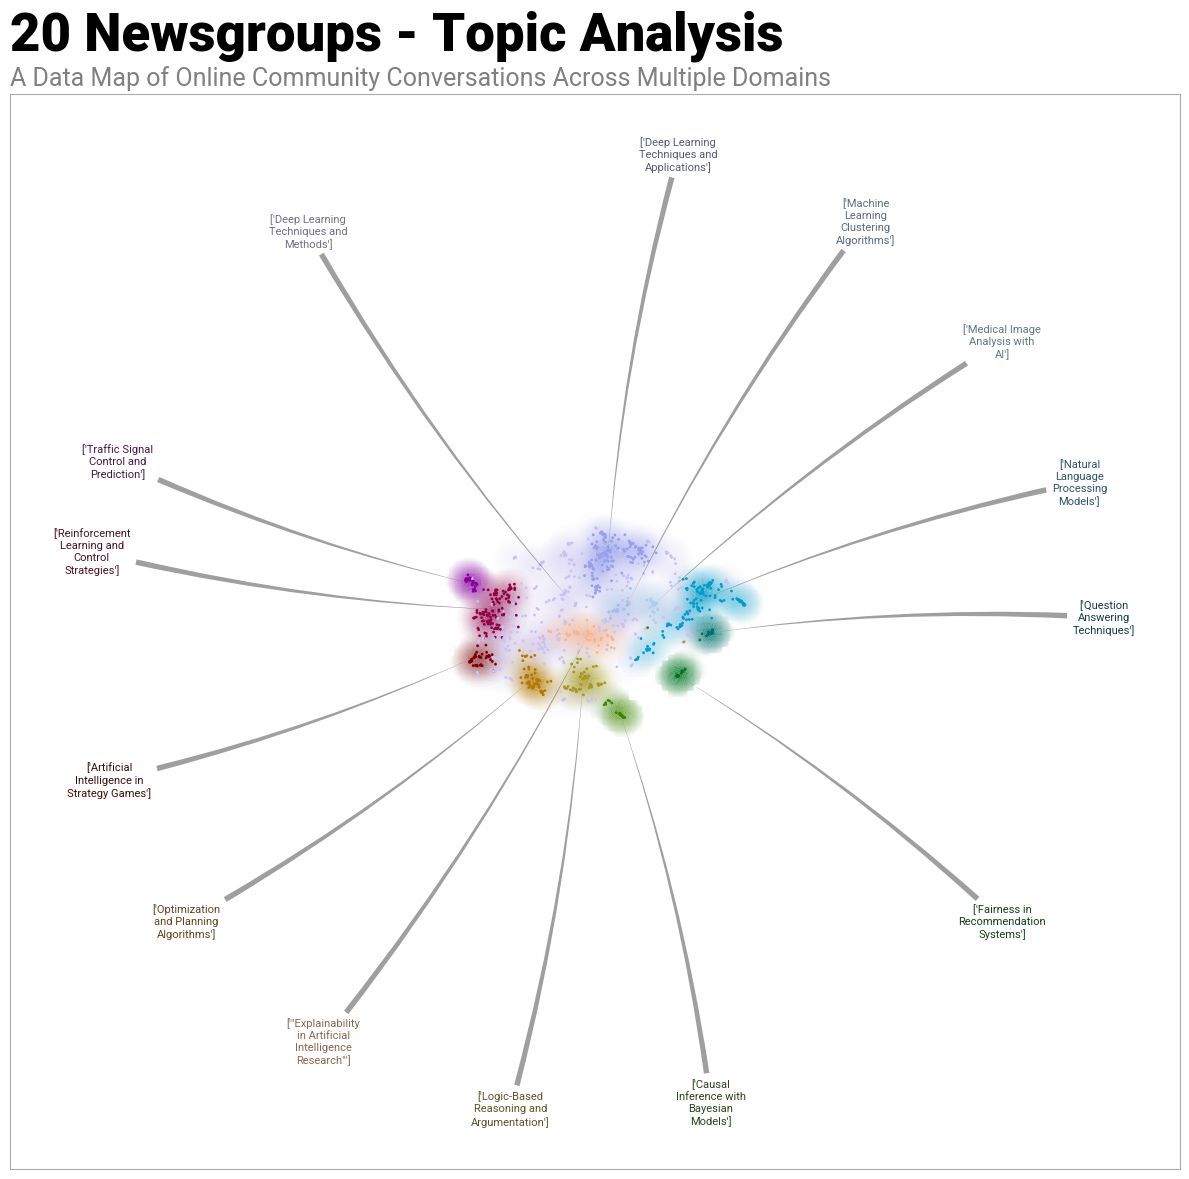

In [46]:
# Run the topic map visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,

    use_medoids=True,

    # Follows matplotlib’s 'figsize' convention.
    # The actual size of the resulting plot (in pixels) will depend on the dots per inch (DPI)
    # setting in matplotlib.
    # By default that is set to 100 dots per inch for the standard backend, but it can vary.
    figsize=(12, 12),
    # If you really wish to have explicit control of the size of the resulting plot in pixels.
    dpi=100,

    title="20 Newsgroups - Topic Analysis",
    sub_title="A Data Map of Online Community Conversations Across Multiple Domains",

    # Takes a dictionary of keyword arguments that is passed through to
    # matplotlib’s 'suptitle' 'fontdict' arguments.
    sub_title_keywords={
        "fontsize":18,
    },

    # Takes a list of text labels to be highlighted.
    # Note: these labels need to match the exact text from your labels array that you are passing in.
    highlight_labels=[
        "Retinopathy Prematurity Screening",
    ],
    # Takes a dictionary of keyword arguments to be applied when styling the labels.
    highlight_label_keywords={
        "fontsize": 12,
        "fontweight": "bold",
        "bbox": {"boxstyle":"round"}
    },

    # By default DataMapPlot tries to automatically choose a size for the text that will allow
    # all the labels to be laid out well with no overlapping text. The layout algorithm will try
    # to accommodate the size of the text you specify here.
    label_font_size=8,
    label_wrap_width=16,
    label_linespacing=1.25,
    # Default is 1.5. Generally, the values of 1.0 and 2.0 are the extremes.
    # With 1.0 you will have more labels at the top and bottom.
    # With 2.0 you will have more labels on the left and right.
    label_direction_bias=1.3,
    # Controls how large the margin is around the exact bounding box of a label, which is the
    # bounding box used by the algorithm for collision/overlap detection.
    # The default is 1.0, which means the margin is the same size as the label itself.
    # Generally, the fewer labels you have the larger you can make the margin.
    label_margin_factor=2.0,
    # Labels are placed in rings around the core data map. This controls the starting radius for
    # the first ring. Note: you need to provide a radius in data coordinates from the center of the
    # data map.
    # The defaul is selected from the data itself, based on the distance from the center of the
    # most outlying points. Experiment and let the DataMapPlot algoritm try to clean it up.
    label_base_radius=15.0,

    # By default anything over 100,000 points uses datashader to create the scatterplot, while
    # plots with fewer points use matplotlib’s scatterplot.
    # If DataMapPlot is using datashader then the point-size should be an integer,
    # say 0, 1, 2, and possibly 3 at most. If however you are matplotlib scatterplot mode then you
    # have a lot more flexibility in the point-size you can use - and in general larger values will
    # be required. Experiment and see what works best.
    point_size=4,

    # Market type. There is only support if you are in matplotlib's scatterplot mode.
    # https://matplotlib.org/stable/api/markers_api.html
    marker_type="o",

    arrowprops={
        "arrowstyle":"wedge,tail_width=0.5",
        "connectionstyle":"arc3,rad=0.05",
        "linewidth":0,
        "fc":"#33333377"
    },

    add_glow=True,
    # Takes a dictionary of keywords that are passed to the 'add_glow_to_scatterplot' function.
    glow_keywords={
        "kernel_bandwidth": 0.75,  # controls how wide the glow spreads.
        "kernel": "cosine",        # controls the kernel type. Default is "gaussian". See https://scikit-learn.org/stable/modules/density.html#kernel-density.
        "n_levels": 32,            # controls how many "levels" there are in the contour plot.
        "max_alpha": 0.9,          # controls the translucency of the glow.
    },

    darkmode=False,
)

plt.tight_layout()

# Save the plot as a PDF, png, and svg file.
plt.show()